<a href="https://colab.research.google.com/github/KhuyenLE-maths/Digit-recognition-with-CNN/blob/main/Digit_recognition_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [37]:
import os
os.chdir('/content/drive/MyDrive/CNN/')


In [ ]:
os.listdir(os.getcwd())

# Import necessary libraries

In [39]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt 

# Loading the dataset 

In [40]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [41]:
print('Train size:', train.shape, 'Test size: ', test.shape)

Train size: (42000, 785) Test size:  (28000, 784)


In [42]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [43]:
set(train['label'])

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [44]:
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


X_train and y_train

In [45]:
y_train = train['label']
X_train = train.drop(labels = ['label'], axis = 1)

In [46]:
y_train

0        1
1        0
2        1
3        4
4        0
        ..
41995    0
41996    1
41997    7
41998    6
41999    9
Name: label, Length: 42000, dtype: int64

In [47]:
X_train.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Visualize number of digits classes

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Number of digits classes')

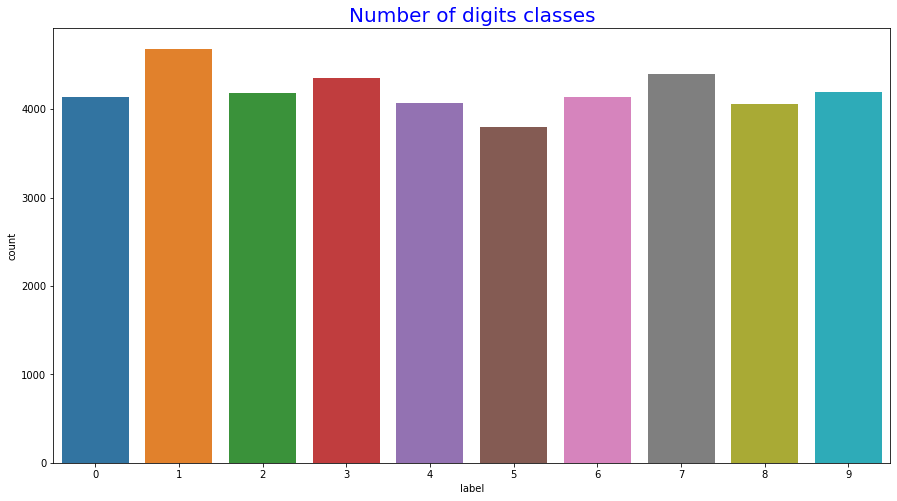

In [48]:
plt.figure(figsize = (15,8))
g = sns.countplot(y_train)
plt.title('Number of digits classes',fontsize = 20, color = 'b')

In [49]:
y_train.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

Visualize randomly 5 iamges in the train set

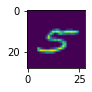

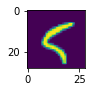

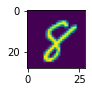

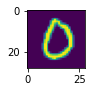

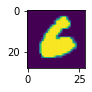

In [50]:
import random
plt.figure()
for i in np.arange(5):
  plt.subplot(1,5,i+1)
  ind = random.randint(0, X_train.shape[0])
  # print(ind)
  img = X_train.iloc[ind].to_numpy()
  img = img.reshape(28,28)
  plt.imshow(img)
  plt.show()

## Normalization, Reshape and Encoding
### Normalization: 
We perfom a grayscale normalization to reduce the effect of illumination's differences. CNN will work faster with normalization. 


In [51]:
X_train = X_train/255
test = test/255

### Reshape:
We reshape all the train and test data to 28*28*1 3D matrices. (Note that Keras needs an extra dimension in the end which corresponds to the chanel numbers. Our images are grayscale, so the number of chanel is only 1)

In [52]:
X_train = X_train.values.reshape(-1,28,28,1)
# X_train.values contains all the row values of X_train: X_train.values[i] is corresponding to the i^th row of X_train ''' 

In [53]:
test = test.values.reshape(-1,28,28,1)

### Label Encoding
Encode labels to one hot vector 
1 --> [0,1, 0, 0, 0, 0, 0, 0, 0]
8 --> [0,0, 0, 0, 0, 0, 0, 1, 0]

In [54]:
from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train, num_classes = 10)

In [55]:
y_train

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

### Train test split
We devide the data into train set (80%) and validation set (20%)

In [56]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 0)

In [57]:
print('Train set:', X_train.shape, 'Val set:', X_val.shape)

Train set: (33600, 28, 28, 1) Val set: (8400, 28, 28, 1)


### Creat model

In [58]:
from sklearn.metrics import confusion_matrix
import itertools

from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dropout, Dense, Flatten, BatchNormalization
from keras.optimizers import RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

We are going to crear 2 models with and without BatchNormalization

In [59]:
model = Sequential()

# layer 1
model.add(Conv2D(filters= 8, kernel_size = (5,5), padding = 'Same', activation = 'relu', input_shape = (28,28,1)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.25))

# layer 2
model.add(Conv2D(filters = 16, kernel_size = (3,3), padding = 'Same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.2))

# layer 3
model.add(Conv2D(filters = 32, kernel_size= (3,3), padding = 'Same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.2))

# fully connected layer 
model.add(Flatten())
model.add(Dense(256, activation= 'relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation = 'softmax'))

In [60]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 8)         208       
_________________________________________________________________
batch_normalization_3 (Batch (None, 28, 28, 8)         32        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 8)         0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 16)        1168      
_________________________________________________________________
batch_normalization_4 (Batch (None, 14, 14, 16)        64        
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 16)         

Model 2 without using BatchNormalization

In [61]:
model2 = Sequential()

# layer1
model2.add(Conv2D(filters = 8, kernel_size = (5,5), padding = 'Same', activation = 'relu', input_shape = (28,28,1)))
model2.add(MaxPool2D(pool_size = (2,2)))
model2.add(Dropout(0.25))

# layer 2
model2.add(Conv2D(filters = 16, kernel_size = (3,3), padding = 'Same', activation = 'relu'))
model2.add(MaxPool2D(pool_size = (2,2)))
model2.add(Dropout(0.25))

# layer 3
model2.add(Conv2D(filters = 32, kernel_size = (3,3), padding = 'Same', activation = 'relu'))
model2.add(MaxPool2D(pool_size = (2,2)))
model2.add(Dropout(0.2))

# fully connected layer 
model2.add(Flatten())
model2.add(Dense(256, activation= 'relu'))
model2.add(Dropout(0.5))
model2.add(Dense(10, activation = 'softmax'))

In [62]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 28, 28, 8)         208       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 8)         0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 14, 14, 16)        1168      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 7, 7, 16)          0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 7, 7, 32)         

### Define Optimizer 

In [63]:
optimizer = Adam(lr = 0.001)

### Compile models
We use categorical crossentropy (CCE): 
   $$ CCE = - \dfrac{1}{N} \sum_{i = 0}^N \sum_{j = 0}^N y_j log ( \hat{y}_j) +    (1-y_j) log (1 - \hat{y}_j) $$ 

In [64]:
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])
model2.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ['accuracy'])

### Data Augmentation

In [65]:
datagen = ImageDataGenerator(
    featurewise_center = False, # (not) set input mean to 0 over the dataset
    samplewise_center = False, # (not) set each sample mean to 0
    featurewise_std_normalization = False, # (not) divide inputs by std of the dataset
    samplewise_std_normalization = False, # (not) devide each sample by its std
    zca_whitening = False, # dimension reduction 
    rotation_range = 5, # randomly rotate images in the range of 5 degress
    zoom_range = 0.1, # randomly zoom images 10%
    width_shift_range = 0.1, # randomly shift images horizontally 10%
    height_shift_range = 0.1, # randomly shift images vertically 10%
    horizontal_flip = False, # (not) randomly flip images horizontally
    vertical_flip = False # (not) randomly flip imagaes vertically
)

In [66]:
os.getcwd()

'/content/drive/MyDrive/CNN'

### Fit models

Fit the first model (which uses BatchNormalization)

In [74]:
epochs = 30
batch_size = 128
from keras.callbacks import ModelCheckpoint
path_file_1 = os.getcwd() + '/' + "weights_case1.hdf5"
checkpoint_1 = ModelCheckpoint(path_file_1, monitor = "loss", save_best_only = True, mode = "auto")
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size), epochs = epochs, 
                              validation_data = (X_val, y_val), steps_per_epoch = X_train.shape[0]//batch_size,
                              callbacks = checkpoint_1)

Epoch 1/30
  3/262 [..............................] - ETA: 7s - loss: 0.1326 - accuracy: 0.9609

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


262/262 [==============================] - 8s 31ms/step - loss: 0.1331 - accuracy: 0.9581 - val_loss: 0.0424 - val_accuracy: 0.9871
Epoch 2/30
262/262 [==============================] - 8s 31ms/step - loss: 0.1236 - accuracy: 0.9626 - val_loss: 0.0412 - val_accuracy: 0.9862
Epoch 3/30
262/262 [==============================] - 8s 32ms/step - loss: 0.1187 - accuracy: 0.9631 - val_loss: 0.0358 - val_accuracy: 0.9881
Epoch 4/30
262/262 [==============================] - 8s 32ms/step - loss: 0.1150 - accuracy: 0.9646 - val_loss: 0.0395 - val_accuracy: 0.9882
Epoch 5/30
262/262 [==============================] - 8s 32ms/step - loss: 0.1115 - accuracy: 0.9650 - val_loss: 0.0328 - val_accuracy: 0.9899
Epoch 6/30
262/262 [==============================] - 8s 32ms/step - loss: 0.1110 - accuracy: 0.9661 - val_loss: 0.0396 - val_accuracy: 0.9873
Epoch 7/30
262/262 [==============================] - 8s 31ms/step - loss: 0.1107 - accuracy: 0.9669 - val_loss: 0.0331 - val_accuracy: 0.9907
Epoch 8/30

Fit the second model (without using BatchNormalization)

In [75]:
path_file_2 = os.getcwd() + '/' + "weights_case2.hdf5"
checkpoint_2 = ModelCheckpoint(path_file_2, monitor = "loss", save_best_only = True, mode = 'auto')
history2 = model2.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size), epochs = epochs, 
                              validation_data = (X_val, y_val), steps_per_epoch = X_train.shape[0]//batch_size, 
                              callbacks = checkpoint_2)

Epoch 1/30
  3/262 [..............................] - ETA: 7s - loss: 0.1642 - accuracy: 0.9583 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


262/262 [==============================] - 8s 31ms/step - loss: 0.1571 - accuracy: 0.9510 - val_loss: 0.0487 - val_accuracy: 0.9836
Epoch 2/30
262/262 [==============================] - 8s 31ms/step - loss: 0.1486 - accuracy: 0.9552 - val_loss: 0.0435 - val_accuracy: 0.9858
Epoch 3/30
262/262 [==============================] - 8s 31ms/step - loss: 0.1479 - accuracy: 0.9546 - val_loss: 0.0422 - val_accuracy: 0.9863
Epoch 4/30
262/262 [==============================] - 8s 31ms/step - loss: 0.1460 - accuracy: 0.9568 - val_loss: 0.0434 - val_accuracy: 0.9840
Epoch 5/30
262/262 [==============================] - 8s 31ms/step - loss: 0.1453 - accuracy: 0.9550 - val_loss: 0.0430 - val_accuracy: 0.9868
Epoch 6/30
262/262 [==============================] - 8s 31ms/step - loss: 0.1397 - accuracy: 0.9571 - val_loss: 0.0427 - val_accuracy: 0.9862
Epoch 7/30
262/262 [==============================] - 8s 32ms/step - loss: 0.1400 - accuracy: 0.9578 - val_loss: 0.0439 - val_accuracy: 0.9849
Epoch 8/30

### Evaluate the two models

Text(0.5, 1.0, 'Model 2 (without BatchNormalization)')

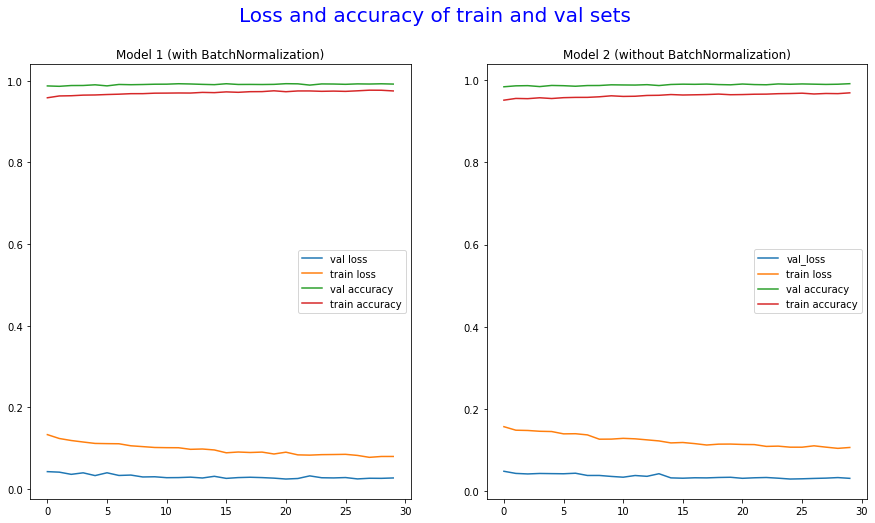

In [76]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,8))
fig.suptitle('Loss and accuracy of train and val sets', fontsize = 20, color = 'b')

ax1.plot(history.history['val_loss'], label = 'val loss')
ax1.plot(history.history['loss'], label = 'train loss')
ax1.plot(history.history['val_accuracy'], label = 'val accuracy')
ax1.plot(history.history['accuracy'], label = 'train accuracy')
ax1.legend()
ax1.set_title('Model 1 (with BatchNormalization)')

ax2.plot(history2.history['val_loss'], label = 'val_loss')
ax2.plot(history2.history['loss'], label = 'train loss')
ax2.plot(history2.history['val_accuracy'], label = 'val accuracy')
ax2.plot(history2.history['accuracy'], label = 'train accuracy')
ax2.legend()
ax2.set_title('Model 2 (without BatchNormalization)')

Based on the figures above, we see that the accuracy obtained from the model 1 (With BatchNormalization) is larger than the accuracy from the model 2 (without BatchNormalization). 

### Confusion matrices corresponding to the two models 

In [77]:
import seaborn as sns 

For the first model

In [78]:
# Predict the values from the validation dataset
y_pred = model.predict(X_val)
# Convert to the names of classes
y_pred_classes = np.argmax(y_pred, axis = 1)

# the true classes 
y_true = np.argmax(y_val, axis = 1)

# compute the confusion matrix
confusion_mat = confusion_matrix(y_true, y_pred_classes)

For the second model 

In [79]:
# Predict the values from the validation dataset 
y_pred_2 = model2.predict(X_val)
# convert to names of classes 
y_pred_classes_2 = np.argmax(y_pred_2, axis = 1)

# compute the confusion matrix
confusion_mat_2 = confusion_matrix(y_true, y_pred_classes_2)

Text(0.5, 1.0, 'Confusion matrix wrt model 2')

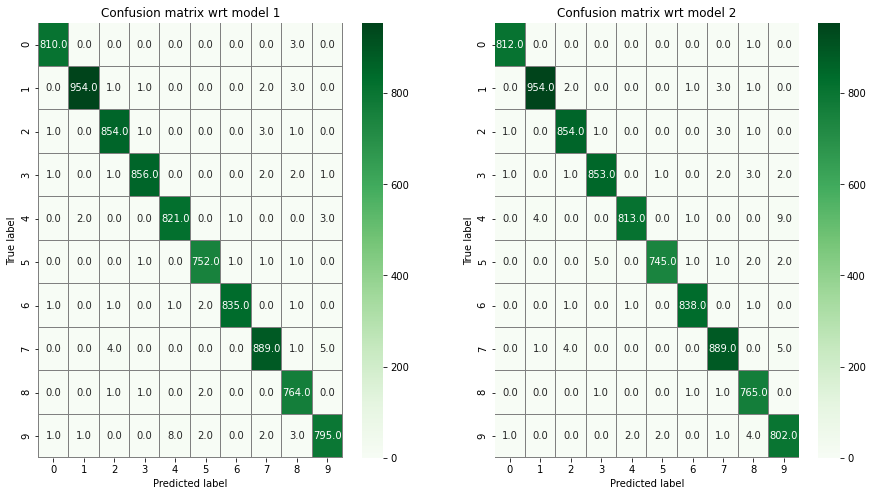

In [80]:
plt.figure(figsize= (15,8))

plt.subplot(1,2,1)
sns.heatmap(confusion_mat, linewidths = 0.1, cmap = 'Greens', linecolor = 'gray', fmt = '.1f', annot = True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix wrt model 1')

plt.subplot(1,2,2)
sns.heatmap(confusion_mat_2, linewidths= 0.01, cmap = 'Greens', linecolor = 'gray', fmt = '.1f', annot = True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix wrt model 2')

Save models

In [81]:
model.save('model_case1.h5')
model2.save('model_case2.h5')

### Predict for the test set

In [87]:
y_test_pred = model.predict(test)
y_test_pred

array([[1.36522935e-08, 2.13824042e-10, 9.99999523e-01, ...,
        4.75068695e-09, 1.72231260e-08, 1.98286054e-09],
       [9.99968648e-01, 1.57606250e-09, 1.15486255e-05, ...,
        2.58801919e-07, 7.50821482e-06, 6.23423057e-06],
       [1.02727635e-11, 6.25200759e-12, 2.69140665e-09, ...,
        2.97660652e-08, 3.53679607e-05, 9.99954343e-01],
       ...,
       [3.33798210e-18, 3.13707990e-13, 9.26466195e-12, ...,
        4.31102043e-10, 2.38999509e-09, 1.39979972e-10],
       [9.42875857e-08, 4.99994769e-07, 4.32926345e-06, ...,
        7.16329814e-05, 3.59555888e-05, 9.96371031e-01],
       [1.55219082e-09, 2.50448295e-12, 9.99999523e-01, ...,
        9.97495142e-11, 2.26750689e-08, 1.33289624e-09]], dtype=float32)

In [89]:
classes_test_pred = np.argmax(y_test_pred, axis = 1)
classes_test_pred 

array([2, 0, 9, ..., 3, 9, 2])

Compare ramdomly the predicted results to the true images

At index:  3587
The predicted result is: 
9
The real image is: 


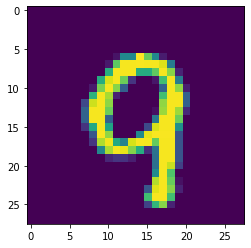

In [106]:
ind = random.randint(0,len(test))
print('At index: ', ind )

print('The predicted result is: ')
print(classes_test_pred[ind])

print('The real image is: ')
plt.imshow(test[ind].reshape(28,28))